# *Bayesian Additive Regression Trees* (BART);

Prof. Daniel de Abreu Pereira Uhr

* Introdução ao modelo *Bayesian Additive Regression Trees* (BART)
* Aplicação em Python

https://www.pymc.io/projects/bart/en/latest/

***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

### Introdução ao modelo *Bayesian Additive Regression Trees* (BART)

**BART** é um modelo de aprendizado de máquina que combina duas ideias centrais:

- A flexibilidade das árvores de regressão (*regression trees*) para capturar relações não lineares e interações entre variáveis;
- A inferência **bayesiana**, que permite quantificar a ***incerteza das previsões*** e ***regularizar o modelo***.

O BART ajusta uma **soma de várias árvores pequenas** (chamadas de *weak learners*), de forma semelhante ao Boosting — mas dentro de um **modelo bayesiano completo**.

* Enquanto o Boosting reduz o viés a qualquer custo, o BART impõe uma regularização natural ao limitar a profundidade e o impacto de cada árvore via as priors. Isso ajuda a evitar overfitting de forma bayesiana.

***Relembrando: o que é um modelo bayesiano?***

> Em vez de buscar apenas um valor “ótimo” para os parâmetros (como nos modelos frequencistas), o modelo bayesiano calcula uma **distribuição de probabilidade** dos parâmetros, **dado os dados observados**.

A intuição aqui é que **estamos mudando o papel das variáveis**: tratamos os dados $D$ como fixos, e os parâmetros $\theta$ como variáveis aleatórias. Ou seja: **dado que observei os dados $D$, qual é a distribuição de probabilidade sobre os parâmetros $\theta$?**

A base para essa atualização de crença é o **Teorema de Bayes**:

$$
P(\theta \mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{P(D)}
$$

Onde:

- $P(\theta \mid D)$: **posterior** – distribuição dos parâmetros após observar os dados;
- $P(D \mid \theta)$: **verossimilhança** – quão compatíveis os dados $D$ são com o parâmetro $\theta$;
- $P(\theta)$: **prior** – distribuição inicial sobre o parâmetro (antes de observar os dados);
- $P(D)$: **função de normalização** – probabilidade marginal dos dados. Ela torna a posteriori uma distribuição válida e permite comparações entre modelos.

> Ou seja: com métodos bayesianos, você começa com uma **crença inicial** (a priori) sobre os parâmetros.  
> Ao observar os dados, você **atualiza** essa crença e obtém a **distribuição a posteriori**.  
> As estimativas deixam de ser apenas um número (como um $\hat{\beta}$) e passam a ser **distribuições completas**, refletindo nossa incerteza.

Na prática, aqui o pesquisador deve especificar:
- Uma **verossimilhança** que descreve como os dados são gerados a partir desses parâmetros.
  * Dados contínuos com erro normal	$Y_i \sim \mathcal{N}(\mu, \sigma^2)$
  * Dados binários (sucesso/fracasso)	$Y_i \sim \text{Bernoulli}(p)$
  * Contagens	$Y_i \sim \text{Poisson}(\lambda)$
  * Tempo até evento	$Y_i \sim \text{Exponencial}(\lambda)$ ou $\text{Weibull}$
* Uma **distribuição a priori** para os parâmetros do modelo (o que acreditamos antes de ver os dados);

***exemplo***
* Modelo normal com média desconhecida: Suponha $Y_i \sim \mathcal{N}(\mu, \sigma^2)$ com $\sigma^2$ conhecida.

Podemos definir:
* Verossimilhança:
$P(y_i \mid \mu) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{(y_i - \mu)^2}{2\sigma^2} \right)$
* Prior (exemplo 1):
$\mu \sim \mathcal{N}(0, 10^2)$ → pouco informativa
* Prior (exemplo 2):
$\mu \sim \mathcal{N}(5, 0.5^2)$ → se você tem conhecimento prévio do valor esperado


***Como o Teorema de Bayes leva ao BART?***

***Etapa 1: Problema de regressão***

Queremos estimar uma função desconhecida $f(x)$ tal que:
$$ y_i = f(x_i) + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2) $$

O que BART vai fazer é modelar $f(x)$ como uma soma de várias árvores de decisão pequenas:

$$
f(x) = \sum_{j=1}^{m} g(x; T_j, M_j)
$$

Então o modelo completo vira:

$$
y_i = \sum_{j=1}^{m} g(x_i; T_j, M_j) + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2)
$$

Os parâmetros desconhecidos são:
* As estruturas das árvores $T_1, ..., T_m$
* Os valores nas folhas $M_1, ..., M_m$
* A variância do erro $\sigma^2$

A ideia bayesiana é: vamos colocar distribuições a priori sobre todos esses parâmetros, e depois aplicar o Teorema de Bayes.

***Etapa 2: Priori + Verossimilhança = Posteriori***

Com base no Teorema de Bayes:

$$
P(T_{1:m}, M_{1:m}, \sigma^2 \mid y, x) \propto P(y \mid x, T_{1:m}, M_{1:m}, \sigma^2) \cdot P(T_{1:m}, M_{1:m}, \sigma^2) $$


Aqui:
* $P(y \mid x, T_{1:m}, M_{1:m}, \sigma^2)$, verossimilhança:
Assume que $y_i \sim \mathcal{N}(f(x_i), \sigma^2)$, com $f(x_i)$ vindo da soma das árvores.
* $P(T_{1:m}, M_{1:m}, \sigma^2)$, priori:
São regras sobre como as árvores devem ser pequenas, rasas, com variância controlada.


***Etapa 3: Como estimamos a posteriori?***

A distribuição a posteriori de todas as árvores é muito complexa para calcular analiticamente.
* Solução: amostramos da posteriori via MCMC (Markov Chain Monte Carlo)
  * A cada passo do MCMC, mantemos todas as outras árvores fixas e atualizamos apenas uma árvore por vez ($T_j$, $M_j$), explorando o espaço das árvores de forma controlada.
  * Atualiza essa árvore por meio de:
  * Gibbs sampling: para os valores nas folhas $M_j$
  * Metropolis-Hastings: para propor mudanças na estrutura $T_j$
  * Repete isso ciclicamente para todas as árvores e $\sigma^2$
  * Depois de muitas iterações, temos amostras da posteriori do modelo completo.


***Etapa 4: Como fazemos predições?***

O MCMC gerou, digamos, S amostras da distribuição posterior.

* Para cada iteração $s = 1, ..., S$, você tem um conjunto de árvores:
* Estruturas das árvores: $T_1^{(s)}, T_2^{(s)}, ..., T_m^{(s)}$
* Valores nas folhas: $M_1^{(s)}, M_2^{(s)}, ..., M_m^{(s)}$
* Variância do erro: $\sigma^{2(s)}$


Dado um novo $x^*$, para cada iteração $s$ da cadeia de Markov, calculamos:

$$
\hat{y}^*_s = \sum_{j=1}^{m} g(x^*; T_j(s), M_j(s))
$$

Então, no final, teremos uma amostra de tamanho $S$ da distribuição preditiva de $y^*$:

$$ 
\hat{y}^* = \left\{ \hat{y}^*_1, \hat{y}^*_2, ..., \hat{y}^*_S \right\}
$$


Previsão pontual (média Bayesiana):

$$
\hat{y}^*_{\text{média}} \approx \frac{1}{S} \sum_{s=1}^{S} \hat{y}^*_s
$$

Incerteza (Intervalo de Credibilidade):

Exemplo de intervalo de 95%:
* Limite inferior: 2,5º percentil da amostra ${ \hat{y}^*_s }$
* Limite superior: 97,5º percentil da amostra ${ \hat{y}^*_s }$


**Resumo da lógica do BART**

| Etapa	| O que é feito	| Papel do Teorema de Bayes| 
|---	|---	|---	|
|1. Modelagem	| $y = f(x) + \varepsilon$, com $f(x)$ sendo soma de árvores pequenas	| Define o objetivo da estimação
|2. Priorização	|Define priors sobre estruturas das árvores, folhas e $\sigma^2$	| Fornece regularização bayesiana |
|3. Verossimilhança	| $y_i \sim \mathcal{N}(f(x_i), \sigma^2)$	| Ligação entre os parâmetros e os dados |
|4. Posteriori |	Usa Bayes para obter distribuição sobre os parâmetros |	$\text{Posterior} \propto \text{Verossimilhança} \cdot \text{Prior}$ |
|5. MCMC |	Gera amostras da posteriori via Gibbs + Metropolis	| Estimativa numérica da posteriori |
|6. Predição |	Média das amostras gera predição, quantis geram incerteza |	Incerteza está incorporada nas amostras| 


### Aplicação em Python

https://www.pymc.io/projects/bart/en/latest/

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


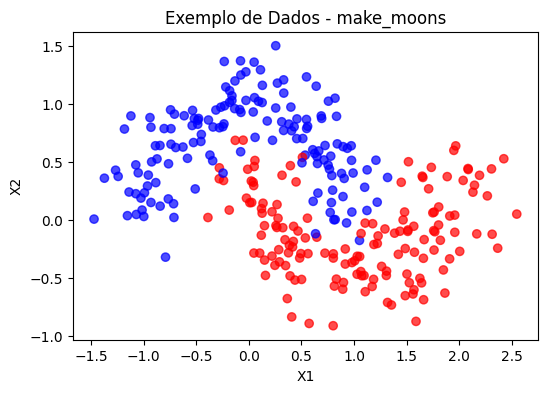

AttributeError: module 'pymc' has no attribute 'BART'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import pymc as pm
import arviz as az

# 1. Gerar os dados
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

# 2. Visualizar os dados
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Exemplo de Dados - make_moons')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# 3. Rodar o modelo BART
with pm.Model() as model:
    # BART para classificação binária
    f = pm.BART("f", X, y, m=50)  # m é o número de árvores
    p = pm.Deterministic("p", pm.math.sigmoid(f))  # Converter para probabilidade (logit link)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, random_seed=42)

# 4. Resumo dos resultados
az.summary(trace, var_names=["p"])

# 5. Visualizar a distribuição das probabilidades preditas
az.plot_posterior(trace, var_names=["p"])
plt.show()


In [2]:
import pymc as pm
print(pm.__version__)


5.15.0


In [3]:
import pymc as pm
print(pm.__version__)


5.15.0


In [4]:
import pymc as pm
print(hasattr(pm, "BART"))


False


In [5]:
pip show pymc


Name: pymc
Version: 5.15.0
Summary: Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with PyTensor
Home-page: http://github.com/pymc-devs/pymc
Author: 
Author-email: 
License: Apache License, Version 2.0
Location: c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: arviz, cachetools, cloudpickle, numpy, pandas, pytensor, rich, scipy, typing-extensions
Required-by: causalimpact, CausalPy
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\danie\appdata\local\programs\python\python311\lib\site-packages\pytz_deprecation_shim-0.1.0.post0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\danie\appdata\local\programs\python\python311\lib\site-packages\rpy2-3.5.12-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\danie\appdata\local\programs\python\python311\lib\site-packages\tzlocal-4.4b1-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
